In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, transpile
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne import inference
from collections import Counter

In [2]:
@cirq.transformer
class SubstituteGate:
    """Transformer to substitute `source` gates with `target` in the input circuit."""

    def __init__(self, source, target):
        self._source = source
        self._target = target

    def __call__(self, circuit, *, context=None):
        batch_replace = []
        for i, op in circuit.findall_operations(lambda op: op.gate == self._source):
            batch_replace.append((i, op, self._target.on(*op.qubits)))
        transformed_circuit = circuit.unfreeze(copy=True)
        transformed_circuit.batch_replace(batch_replace)
        return transformed_circuit

substitute_h_inv = SubstituteGate(cirq.H**-1.0,cirq.H)
substitute_cnot_inv = SubstituteGate(cirq.CNOT**-1.0,cirq.CNOT)

In [3]:
#RCNOT implements CNOT(control,target)
#with 4 Hadamards and CNOT(target,control)
def RCNOT(control,target):
    yield cirq.H(control)
    yield cirq.H(target)
    yield cirq.CNOT(target,control)
    yield cirq.H(control)
    yield cirq.H(target)

#Reminder: cirq.CNOT(control,target)
#Reference:
#https://quantumcomputing.stackexchange.com/questions/9623/constructing-a-circuit-for-c1u-for-rotation-operators-with-two-single-qubit
def cRy(theta,control,target,reverse=False):
    if reverse:
        yield from RCNOT(control,target)
    else:
        yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=-theta/2).on(target)
    if reverse:
        yield from RCNOT(control,target)
    else:
        yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=theta/2).on(target)

def zz_xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.X(env[0])
    yield from RCNOT(sys[0],env[0])
    yield from cRy(2*np.arcsin(np.sqrt(p)),env[0],sys[0])
    yield from RCNOT(sys[0],env[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[1])
    yield from RCNOT(sys[1],env[1])
    yield from cRy(2*np.arcsin(np.sqrt(p)),env[1],sys[1])
    yield from RCNOT(sys[1],env[1])

In [4]:
env = [cirq.LineQubit(0),cirq.LineQubit(3)]
sys = [cirq.LineQubit(1),cirq.LineQubit(2)]
probs = np.linspace(0,1,num=5)
repcnt = 1024

<hr></hr>

In [5]:
np.cos(2*np.arcsin(np.sqrt(0.5))/2)

0.7071067811865475

In [6]:
np.sin(2*np.arcsin(np.sqrt(0.5))/2)

0.7071067811865476

In [7]:
1/np.sqrt(2)

0.7071067811865475

<h2>Testing circuit and decompositions:</h2>

In [8]:
test_circuit = cirq.Circuit(zz_xx_pump(sys,env,1.0))
test_circuit.append(cirq.measure(sys, key = 'answer'))
print(test_circuit)

0: ───X───H───@───H───@───────────────@───────────H─────────────────────@───H─────────────────────
              │       │               │                                 │
1: ───X───H───X───H───X───Ry(-0.5π)───X───────────Ry(0.5π)───H──────────X───H───────M('answer')───
      │                                                                             │
2: ───@───H───H───X───H───X───────────Ry(-0.5π)───X──────────Ry(0.5π)───H───X───H───M─────────────
                  │       │                       │                         │
3: ───X───H───────@───H───@───────────────────────@──────────H──────────────@───H─────────────────


In [9]:
#Decomposition of Hadamard into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
had_circuit = cirq.Circuit([cirq.H(q0),cirq.H(q0)])
had_qiskit = QuantumCircuit.from_qasm_str(had_circuit.to_qasm())
had_t = transpile(had_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(had_qiskit)
print(had_t)

   ┌───┐┌───┐
q: ┤ H ├┤ H ├
   └───┘└───┘
global phase: π/2
   ┌─────────┐┌────┐┌─────────┐┌─────────┐┌────┐┌─────────┐
q: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├
   └─────────┘└────┘└─────────┘└─────────┘└────┘└─────────┘


In [10]:
#Decomposition of CNOT into OQC/IBM basis gates
cnot_circuit = cirq.Circuit([cirq.CNOT(q0,q1),cirq.CNOT(q0,q1)])
cnot_qiskit = QuantumCircuit.from_qasm_str(cnot_circuit.to_qasm())
cnot_t = transpile(cnot_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(cnot_qiskit)
print(cnot_t)

               
q_0: ──■────■──
     ┌─┴─┐┌─┴─┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘
global phase: π
     ┌──────────┐                                       ┌──────┐   ┌───┐   »
q_0: ┤ Rz(-π/2) ├───────────────────────────────────────┤0     ├───┤ X ├───»
     ├─────────┬┘┌─────────┐┌────┐┌─────────┐┌─────────┐│  Ecr │┌──┴───┴──┐»
q_1: ┤ Rz(π/2) ├─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤1     ├┤ Rz(π/2) ├»
     └─────────┘ └─────────┘└────┘└─────────┘└─────────┘└──────┘└─────────┘»
«     ┌──────────┐                            ┌──────┐┌───┐
«q_0: ┤ Rz(-π/2) ├────────────────────────────┤0     ├┤ X ├
«     ├─────────┬┘┌────┐┌─────────┐┌─────────┐│  Ecr │└───┘
«q_1: ┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤1     ├─────
«     └─────────┘ └────┘└─────────┘└─────────┘└──────┘     


In [11]:
#Decomposition of Ry into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
ry_circuit = cirq.Circuit([cirq.Ry(rads=0.5).on(q0)])
ry_qiskit = QuantumCircuit.from_qasm_str(ry_circuit.to_qasm())
ry_t = transpile(ry_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(ry_qiskit)
print(ry_t)

   ┌─────────┐
q: ┤ Ry(0.5) ├
   └─────────┘
global phase: 3π/2
   ┌───────┐┌────┐┌────────────┐┌────┐┌────────┐
q: ┤ Rz(0) ├┤ √X ├┤ Rz(3.6416) ├┤ √X ├┤ Rz(3π) ├
   └───────┘└────┘└────────────┘└────┘└────────┘


In [12]:
#Decomposition of Rx into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
rx_circuit = cirq.Circuit([cirq.Rx(rads=0.5).on(q0)])
rx_qiskit = QuantumCircuit.from_qasm_str(rx_circuit.to_qasm())
rx_t = transpile(rx_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(rx_qiskit)
print(rx_t)

   ┌─────────┐
q: ┤ Rx(0.5) ├
   └─────────┘
global phase: 3π/2
   ┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐
q: ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.6416) ├┤ √X ├┤ Rz(5π/2) ├
   └─────────┘└────┘└────────────┘└────┘└──────────┘


In [13]:
#Decomposition of X into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
cry_circuit = cirq.Circuit(cRy(0.5,q1,q0))
cry_qiskit = QuantumCircuit.from_qasm_str(cry_circuit.to_qasm())
cry_t = transpile(cry_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(cry_t.depth())
print(cry_qiskit)
print(cry_t)

22
     ┌───┐┌───────────┐┌───┐┌──────────┐
q_0: ┤ X ├┤ Ry(-0.25) ├┤ X ├┤ Ry(0.25) ├
     └─┬─┘└───────────┘└─┬─┘└──────────┘
q_1: ──■─────────────────■──────────────
                                        
     ┌─────────┐ ┌─────────┐┌────┐┌─────────┐┌─────────┐┌──────┐┌───────┐»
q_0: ┤ Rz(π/2) ├─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤1     ├┤ Rz(0) ├»
     ├─────────┴┐└─────────┘└────┘└─────────┘└─────────┘│  Ecr │└─┬───┬─┘»
q_1: ┤ Rz(-π/2) ├───────────────────────────────────────┤0     ├──┤ X ├──»
     └──────────┘                                       └──────┘  └───┘  »
«        ┌────┐   ┌────────────┐┌────┐┌────────┐┌─────────┐┌─────────┐┌────┐»
«q_0: ───┤ √X ├───┤ Rz(2.8916) ├┤ √X ├┤ Rz(3π) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├»
«     ┌──┴────┴──┐└────────────┘└────┘└────────┘└─────────┘└─────────┘└────┘»
«q_1: ┤ Rz(-π/2) ├──────────────────────────────────────────────────────────»
«     └──────────┘                                                          »
«     ┌─────────┐┌─────────

<hr></hr>

<h2>Circuit creation:</h2>

In [14]:
provider = IBMProvider()
backend = provider.get_backend('ibm_kyoto')

In [15]:
print(backend.max_circuits)

300


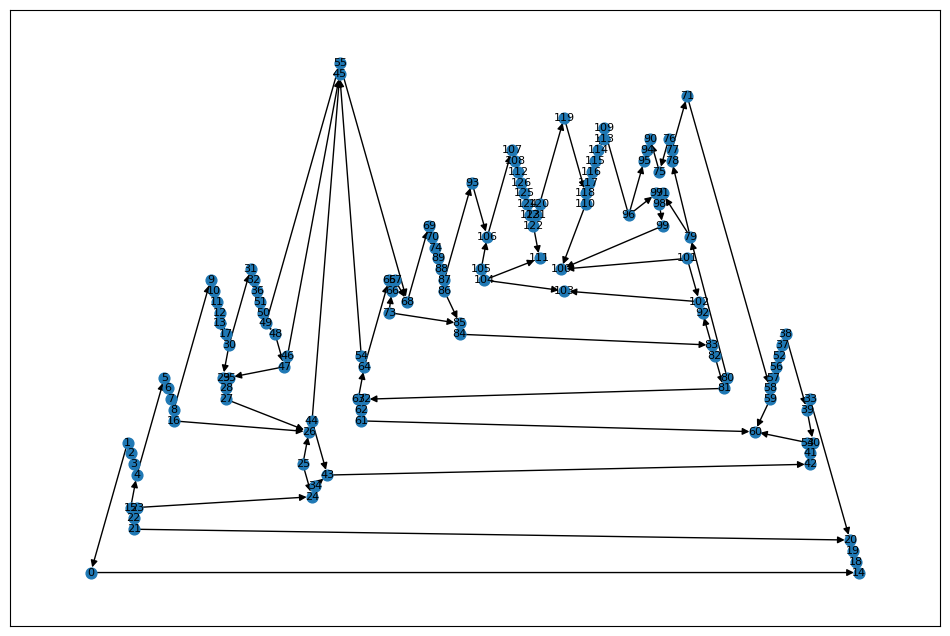

In [16]:
#Run this cell to get a view of the qubit layout
import networkx as nx
G=nx.DiGraph(list(backend.coupling_map))
plt.figure(1,figsize=(12,8)) 
nx.draw_networkx(G,pos=nx.planar_layout(G),node_size=60,font_size=8)
plt.show()

In [17]:
test_circuit = cirq.Circuit(zz_xx_pump(sys,env,1.0))
test_circuit.append(cirq.measure(sys, key = 'answer'))
print(test_circuit)

0: ───X───H───@───H───@───────────────@───────────H─────────────────────@───H─────────────────────
              │       │               │                                 │
1: ───X───H───X───H───X───Ry(-0.5π)───X───────────Ry(0.5π)───H──────────X───H───────M('answer')───
      │                                                                             │
2: ───@───H───H───X───H───X───────────Ry(-0.5π)───X──────────Ry(0.5π)───H───X───H───M─────────────
                  │       │                       │                         │
3: ───X───H───────@───H───@───────────────────────@──────────H──────────────@───H─────────────────


In [18]:
initial_layout = [19,20,21,22]
print(initial_layout)

[19, 20, 21, 22]


In [19]:
scale_factors = [1,3,5,7]

In [20]:
circ_list = []
for scale_factor in scale_factors:
    for p in probs:
        for j in range(2**2):
            circuit = cirq.Circuit()
            if (j&1) == 1:
                circuit.append(cirq.X.on(sys[0]))
            if (j&2) == 2:
                circuit.append(cirq.X.on(sys[1]))
            circuit.append(zz_xx_pump(sys,env,p))
            circuit_folded = fold_gates_at_random(circuit,scale_factor)
            circuit_transformed = substitute_cnot_inv(substitute_h_inv(circuit_folded))
            circuit_transformed.append(cirq.measure(sys, key = 'answer'))
            circuit_qiskit = QuantumCircuit.from_qasm_str(circuit_transformed.to_qasm())
            transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
            circ_list.append(transpiled_circuit)

In [21]:
#circ_list[0].draw()

<h2>Circuit depth scaling plot:</h2>

In [22]:
from scipy.stats import linregress
from scipy.optimize import curve_fit
def cfit(x,a,b):
    return a*x+b
circ_depth_sca = []
for scale_factor in scale_factors:
    circuit = cirq.Circuit(zz_xx_pump(sys,env,p))
    circuit_folded = fold_gates_at_random(circuit,scale_factor)
    circuit_transformed = substitute_cnot_inv(substitute_h_inv(circuit_folded))
    circuit_qiskit = QuantumCircuit.from_qasm_str(circuit_transformed.to_qasm())
    transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
    circ_depth_sca.append(transpiled_circuit.depth())
    # circ_depth_sca.append(len(circuit_folded))
popt,pcov = curve_fit(cfit,scale_factors,np.array(circ_depth_sca))

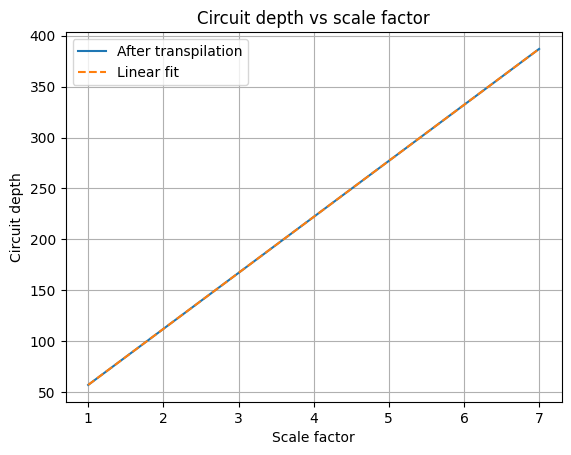

In [23]:
plt.plot(scale_factors,np.array(circ_depth_sca),label='After transpilation')
plt.plot(scale_factors,popt[0]*np.array(scale_factors)+popt[1],linestyle='--',label='Linear fit')
plt.title('Circuit depth vs scale factor')
plt.xlabel('Scale factor')
plt.ylabel('Circuit depth')
plt.legend()
plt.grid()
plt.show()

<h2>Helper functions:</h2>

In [24]:
def return_counts_scaled(job_id,p,sf,shots):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(4,p,sf)) #(type,prob,scale_factor)
    for j in range(sf):
        for i in range(p):
            probs_f = np.zeros(2**2)
            for k in range(2**2):
                cnt = counts[np.ravel_multi_index((j,i,k),(sf,p,2**2))]
                for key,val in cnt.items():
                    probs_f[int(key,2)] += val/shots
            res[:,i,j] = probs_f[:]/4
    return res

In [25]:
def mitigate(scale_factors,exp_vals,extrapolation_method):
    mit_val = None
    if extrapolation_method == 'richardson':
        return inference.RichardsonFactory.extrapolate(scale_factors,exp_vals)
    elif extrapolation_method == 'poly2':
        return inference.PolyFactory.extrapolate(scale_factors,exp_vals,2)
    elif extrapolation_method == 'linear':
        return inference.LinearFactory.extrapolate(scale_factors,exp_vals)
    else:
        raise ValueError('Unrecogized extrapolation method')

In [26]:
def get_mitigated_vals(scale_factors,res,p,extrapolation_method):
    res_mit = np.zeros((4,p))
    for j in range(p):
        for i in range(2**2):
            res_mit[i,j] = mitigate(scale_factors,res[i,j,:],extrapolation_method)
    return res_mit

In [27]:
def improvement_factor(unmit,mit,theory):
    return np.abs((theory-unmit)/(theory-mit))

In [28]:
def calc_pump_sim(pump,sys,env,p,repcnt):
    
    simulator = cirq.Simulator()
    final_hist = Counter()
    
    for j in range(2**2):
        circuit = cirq.Circuit()
        if (j&1) == 1:
            circuit.append(cirq.X.on(sys[0]))
        if (j&2) == 2:
            circuit.append(cirq.X.on(sys[1]))
        circuit.append(pump(sys,env,p))
        circuit.append(cirq.measure(sys, key = 'answer'))
        
        result = simulator.run(circuit,repetitions=repcnt)
        histogram = result.histogram(key = 'answer')
        final_hist += histogram

    for x in final_hist:
        final_hist[x]/=(4*repcnt)

    return final_hist

def calc_plot(hists):
    pops = [[],[],[],[]]
    for counts in hists:
        for i in range(4):
            pops[i].append(counts[i])
    return pops

sim_probs = np.linspace(0,1,num=20)
hists = [calc_pump_sim(zz_xx_pump,sys,env,p,20000) for p in sim_probs]
hists_marker = [calc_pump_sim(zz_xx_pump,sys,env,p,20000) for p in probs]
pops = calc_plot(hists)
pops_marker = calc_plot(hists_marker)

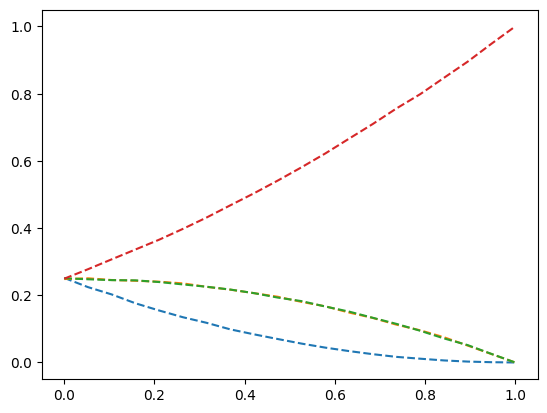

In [29]:
plt.plot(sim_probs,pops[0],linestyle='--')
plt.plot(sim_probs,pops[1],linestyle='--')
plt.plot(sim_probs,pops[2],linestyle='--')
plt.plot(sim_probs,pops[3],linestyle='--')

<h2>Running job:</h2>

In [30]:
with open('./Jobs/MRE/3_victor_kyoto.txt','x') as job_id_file:
        job = backend.run(circ_list,shots=repcnt)   #Run job
        job_id_file.write(job.job_id()+'\n')    #Write to file
        print('Submitted job with job id '+job.job_id())

print('All complete.')

Submitted job with job id cp2qqrfyx18g008yn7gg
All complete.


<h2>Analysing results:</h2>

In [30]:
job_id = 'cp2qqrfyx18g008yn7gg'
res = return_counts_scaled(job_id,probs.shape[0],len(scale_factors),repcnt)

In [31]:
res_mit_poly2 = get_mitigated_vals(scale_factors,res,probs.shape[0],'poly2')
res_mit_richardson = get_mitigated_vals(scale_factors,res,probs.shape[0],'richardson')
res_mit_linear = get_mitigated_vals(scale_factors,res,probs.shape[0],'linear')
res_unmit = res[...,0]

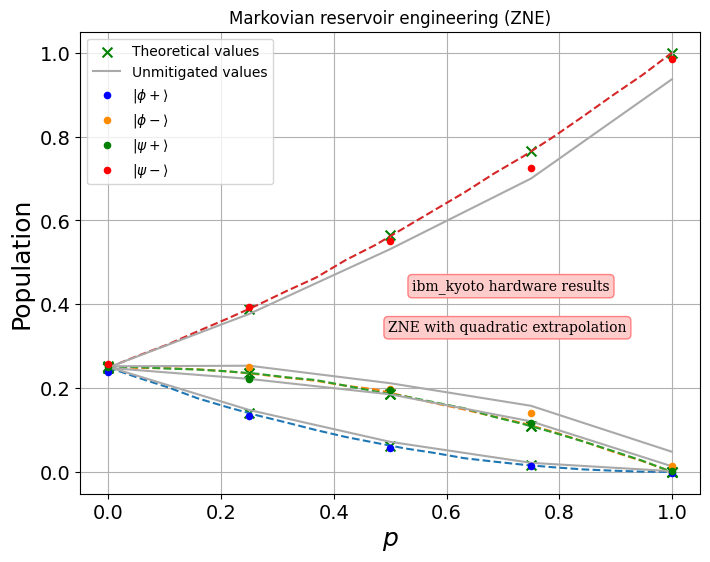

In [47]:
res_plot = res_mit_poly2
font = {'family': 'serif',
        #'color':  'darkred',
        'weight': 'normal',
        'size': 10,
        }
plt.figure(figsize=(8,6))
plt.plot(sim_probs,pops[0],linestyle='--')
plt.plot(sim_probs,pops[1],linestyle='--')
plt.plot(sim_probs,pops[2],linestyle='--')
plt.plot(sim_probs,pops[3],linestyle='--')

plt.scatter(probs,pops_marker[0],s=50,label='Theoretical values',marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[1],s=50,marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[2],s=50,marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[3],s=50,marker='x',c='green',zorder=1)

plt.plot(probs,res_unmit[0,:],label='Unmitigated values',c='darkgrey',zorder=2)
plt.plot(probs,res_unmit[1,:],c='darkgrey',zorder=2)
plt.plot(probs,res_unmit[2,:],c='darkgrey',zorder=2)
plt.plot(probs,res_unmit[3,:],c='darkgrey',zorder=2)

plt.scatter(probs,res_plot[0,:],s=20,label=r'$\vert \phi+ \rangle$',c='blue',zorder=3)
plt.scatter(probs,res_plot[1,:],s=20,label=r'$\vert \phi- \rangle$',c='darkorange',zorder=3)
plt.scatter(probs,res_plot[2,:],s=20,label=r'$\vert \psi+ \rangle$',c='green',zorder=3)
plt.scatter(probs,res_plot[3,:],s=20,label=r'$\vert \psi- \rangle$',c='red',zorder=3)

plt.xlabel(r'$p$',fontsize=18)
#plt.ylabel(r'$\rho_{12}$',fontsize=14)
plt.ylabel(r'Population',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.figtext(0.54, 0.45, 'ibm_kyoto hardware results',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)

plt.figtext(0.51, 0.38, 'ZNE with quadratic extrapolation',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)
plt.grid()
plt.title(r'Markovian reservoir engineering (ZNE)')
plt.legend(fontsize=10)
plt.savefig("mre_kyoto_results_quadratic.pdf", bbox_inches='tight', dpi = 400)
plt.show()

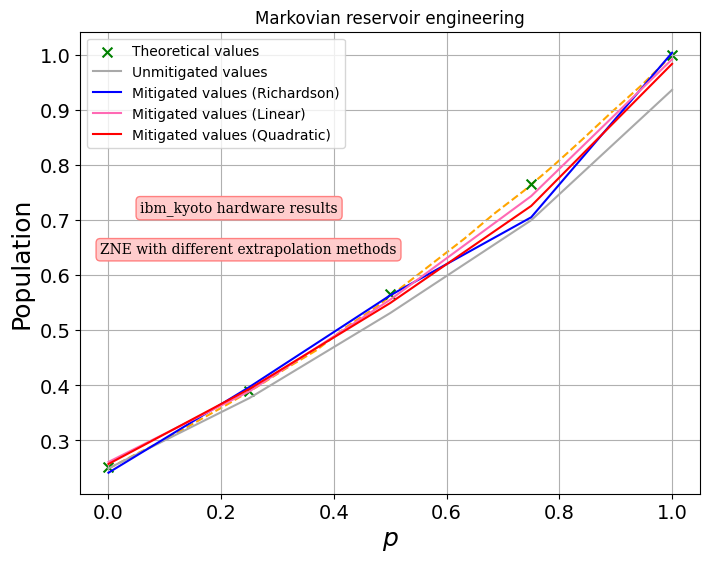

In [63]:
kind = 3
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(8,6))
plt.plot(sim_probs,pops[kind],linestyle='--',c='orange',zorder=0)
plt.scatter(probs,pops_marker[kind],s=50,label='Theoretical values',marker='x',c='green',zorder=1)
plt.plot(probs,res_unmit[kind],label='Unmitigated values',c='darkgrey',zorder=2)
plt.plot(probs,res_mit_richardson[kind],label='Mitigated values (Richardson)',c='blue',zorder=3)
plt.plot(probs,res_mit_linear[kind],label='Mitigated values (Linear)',c='hotpink',zorder=3)
plt.plot(probs,res_mit_poly2[kind],label='Mitigated values (Quadratic)',c='red',zorder=3)
plt.xlabel(r'$p$',fontsize=18)
plt.ylabel('Population',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

plt.figtext(0.2, 0.58, 'ibm_kyoto hardware results',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)

plt.figtext(0.15, 0.51, 'ZNE with different extrapolation methods',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)


plt.title(r'Markovian reservoir engineering')
plt.legend(fontsize=10)
plt.savefig("mre_kyoto_results_different_extrapolations.pdf", bbox_inches='tight', dpi = 400)
plt.show()

38.32073277062757
5.697374121452736
3.2675686460700804


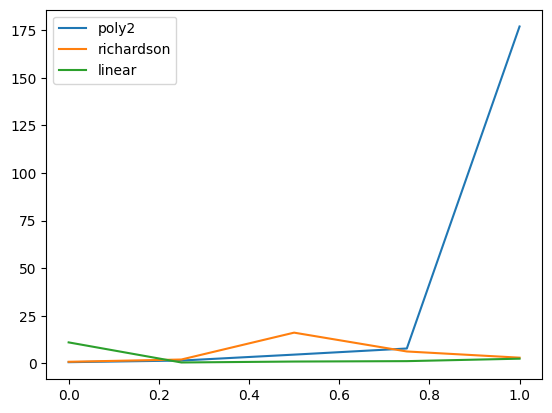

In [76]:
theory = pops_marker[kind]
if_poly2 = improvement_factor(res_unmit[kind],res_rem_mit_poly2[kind],theory)
if_richardson = improvement_factor(res_unmit[kind],res_mit_richardson[kind],theory)
if_linear = improvement_factor(res_unmit[kind],res_mit_linear[kind],theory)
print(np.mean(if_poly2))
print(np.mean(if_richardson))
print(np.mean(if_linear))
plt.plot(probs,if_poly2,label='poly2')
plt.plot(probs,if_richardson,label='richardson')
plt.plot(probs,if_linear,label='linear')
plt.legend()
plt.show()

<h2>Trying readout error mitigation:</h2>

In [48]:
from mitiq.rem import generate_tensored_inverse_confusion_matrix
from mitiq.rem.inverse_confusion_matrix import mitigate_measurements
from mitiq.typing import MeasurementResult

In [49]:
p1_01 = 0.0394
p1_10 = 0.0196
p2_01 = 0.0102
p2_10 = 0.0092
A1 = [[1-p1_10, p1_01],[p1_10,1-p1_01]]
A2 = [[1-p2_10, p2_01],[p2_10,1-p2_01]]
A_pinv = generate_tensored_inverse_confusion_matrix(2, confusion_matrices=[A1, A2])

In [50]:
print(A_pinv)

[[ 1.03040633e+00 -1.06184528e-02 -4.22631788e-02  4.35526797e-04]
 [-9.57742803e-03  1.03144736e+00  3.92828091e-04 -4.23058775e-02]
 [-2.10243224e-02  2.16658000e-04  1.05164519e+00 -1.08373216e-02]
 [ 1.95417020e-04 -2.10455634e-02 -9.77483910e-03  1.05270767e+00]]


In [51]:
def return_counts_mitigated(job_id,p,sf,shots,inv_conf_mat):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(4,p,sf)) #(type,prob,scale_factor)
    for j in range(sf):
        for i in range(p):
            probs_f = np.zeros(2**2)
            for k in range(2**2):
                cnt = counts[np.ravel_multi_index((j,i,k),(sf,p,2**2))]
                cnt_ms = MeasurementResult.from_counts(cnt)
                cnt_mit = mitigate_measurements(cnt_ms,inv_conf_mat)
                for key,val in cnt_mit.get_counts().items():
                    probs_f[int(key,2)] += val/shots
            res[:,i,j] = probs_f[:]/4
    return res

In [52]:
res_rem = return_counts_mitigated(job_id,probs.shape[0],len(scale_factors),repcnt,A_pinv)
res_rem_mit_poly2 = get_mitigated_vals(scale_factors,res_rem,probs.shape[0],'poly2')
res_rem_mit_richardson = get_mitigated_vals(scale_factors,res_rem,probs.shape[0],'richardson')
res_rem_mit_linear = get_mitigated_vals(scale_factors,res_rem,probs.shape[0],'linear')
res_rem_unmit = res_rem[...,0]

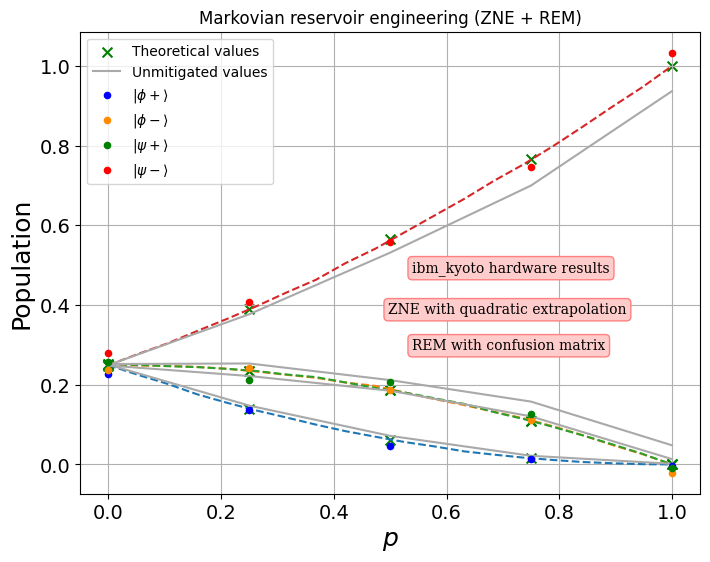

In [56]:
res_plot = res_rem_mit_poly2
res_compare = res_unmit
plt.figure(figsize=(8,6))
plt.plot(sim_probs,pops[0],linestyle='--')
plt.plot(sim_probs,pops[1],linestyle='--')
plt.plot(sim_probs,pops[2],linestyle='--')
plt.plot(sim_probs,pops[3],linestyle='--')

plt.scatter(probs,pops_marker[0],s=50,label='Theoretical values',marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[1],s=50,marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[2],s=50,marker='x',c='green',zorder=1)
plt.scatter(probs,pops_marker[3],s=50,marker='x',c='green',zorder=1)

plt.plot(probs,res_compare[0,:],label='Unmitigated values',c='darkgrey',zorder=2)
plt.plot(probs,res_compare[1,:],c='darkgrey',zorder=2)
plt.plot(probs,res_compare[2,:],c='darkgrey',zorder=2)
plt.plot(probs,res_compare[3,:],c='darkgrey',zorder=2)

plt.scatter(probs,res_plot[0,:],s=20,label=r'$\vert \phi+ \rangle$',c='blue',zorder=3)
plt.scatter(probs,res_plot[1,:],s=20,label=r'$\vert \phi- \rangle$',c='darkorange',zorder=3)
plt.scatter(probs,res_plot[2,:],s=20,label=r'$\vert \psi+ \rangle$',c='green',zorder=3)
plt.scatter(probs,res_plot[3,:],s=20,label=r'$\vert \psi- \rangle$',c='red',zorder=3)

plt.xlabel(r'$p$',fontsize=14)
#plt.ylabel(r'$\rho_{12}$',fontsize=14)
plt.ylabel('Population',fontsize=14)
plt.title(r'Markovian reservoir engineering (ZNE + REM)')
plt.legend(fontsize=10)


plt.xlabel(r'$p$',fontsize=18)
#plt.ylabel(r'$\rho_{12}$',fontsize=14)
plt.ylabel('Population',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.figtext(0.54, 0.48, 'ibm_kyoto hardware results',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)

plt.figtext(0.51, 0.41, 'ZNE with quadratic extrapolation',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)


plt.figtext(0.54, 0.35, 'REM with confusion matrix',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)



plt.grid()
plt.savefig("mre_kyoto_results_zne_rem.pdf", bbox_inches='tight', dpi = 400)
plt.show()